## Импортируем нужные библиотеки, вспомогательные функции

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

# Вспомогательные функции вынесены в отдельный файл
from agent import Agent
from misc import train_dqn, watch_agent, plot_scores

## Окружение

In [2]:
env = gym.make('LunarLander-v2')
env.seed(0)
state_size = env.observation_space.shape
action_size = env.action_space.n
print('State shape: ', state_size)
print('Number of actions: ', action_size)
state_size = state_size[0]

/home/dantatartes/miniconda3/envs/py3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


State shape:  (8,)
Number of actions:  4


## Агенты

### Untrained agent

In [3]:
untrained_agent = Agent(state_size, action_size, seed=0)
watch_agent(untrained_agent, env)

В качестве baseline возьмём решение [Daniel T. Plop](https://github.com/plopd/deep-reinforcement-learning/tree/master/dqn)

### [Default DQN](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf)

Episode 100	Average Score: -130.85
Episode 200	Average Score: -66.622
Episode 300	Average Score: 24.144
Episode 400	Average Score: 180.55
Episode 418	Average Score: 200.02
Environment solved in 318 episodes!	Average Score: 200.02


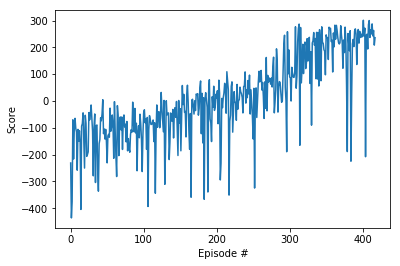

In [4]:
scores_default = train_dqn(untrained_agent, env, save_as='checkpoint_default')
plot_scores(scores_default)

## [Double](https://arxiv.org/abs/1509.06461) DQN

Идея Double Q-learning заключается в уменьшении переоценки через замену max-операции в выбор действия и его подсчёт. Хотя и не полностью разделённая, архитектура Double DQN кандидата для второй V(s) функции без нужды в дополнительной нейронной сети. Поэтому предлагается оценивать greedy policy согласно локальной нейронке, но использовать целевую для подсчёта значения.
Т.е, вместо получения максимальных прогнозируемых значений q для target model
```python
Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
```
Мы используем greedy-actions для будущего состояния в local model, чтобы потом получить значение q из target model по Q_local_argmax
```python
Q_local_argmax = self.qnetwork_local(next_states).detach().argmax(dim=1).unsqueeze(1)
Q_targets_next = self.qnetwork_target(next_states).gather(1, Q_local_argmax).detach()
```

Episode 100	Average Score: -151.53
Episode 200	Average Score: -54.884
Episode 300	Average Score: 6.5146
Episode 400	Average Score: 151.69
Episode 440	Average Score: 201.04
Environment solved in 340 episodes!	Average Score: 201.04


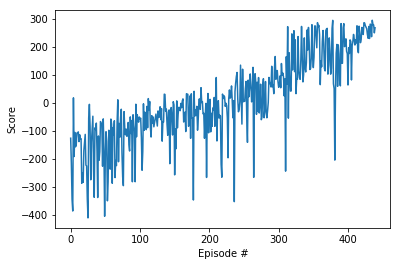

In [4]:
agent = Agent(state_size, action_size, seed=0, double=True)
scores_double = train_dqn(agent, env, save_as='checkpoint_double')
plot_scores(scores_double)

In [ ]:
agent = Agent(state_size, action_size, seed=0, double=True)
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_double.pth'))
watch_agent(agent, env)

## [Dueling](https://arxiv.org/abs/1511.06581) DQN

На интуитивном уровне, dueling-архитектура позволяет определять какие состояния выгодны (а какие нет), без обязанности просчитывать эффект каждого действия для каждого состояния. Это особенно полезно в состояниях где действия в нём не влияют на окружение в какой-либо мере.

![Dueling-DQN](files/img/dueling.png)

Нужно просто создать отдельный слой для V(s) и A(s, a),
затем сложить их в конце по формуле: Q(s,a) = V(s) + (A(s,a) - 1/|A| * sum A(s,a'))

Episode 100	Average Score: -129.72
Episode 200	Average Score: -78.068
Episode 300	Average Score: -3.728
Episode 382	Average Score: 200.27
Environment solved in 282 episodes!	Average Score: 200.27


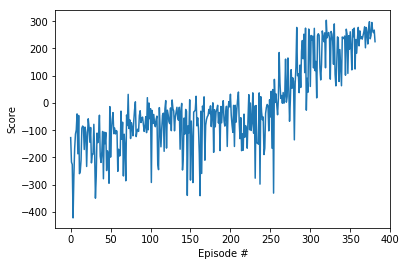

In [3]:
agent = Agent(state_size, action_size, seed=0, dueling=True)
scores_dueling = train_dqn(agent, env, save_as='checkpoint_dueling')
plot_scores(scores_dueling)

In [5]:
agent = Agent(state_size, action_size, seed=0, dueling=True)
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_dueling.pth'))
watch_agent(agent, env)

#### Решено в 282 эпизода

In [4]:
agent = Agent(state_size, action_size, seed=0, dueling=True)
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_dueling.pth'))
watch_agent(agent, env)

## Dueling Double DQN

Попробуем просто наложить две технологии

Episode 100	Average Score: -136.42
Episode 200	Average Score: -38.171
Episode 300	Average Score: 78.181
Episode 396	Average Score: 200.62
Environment solved in 296 episodes!	Average Score: 200.62


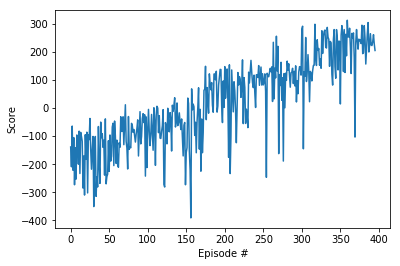

In [5]:
agent = Agent(state_size, action_size, seed=0, dueling=True, double=True)
scores_DDDQN = train_dqn(agent, env, save_as='checkpoint_DDDQN')
plot_scores(scores_DDDQN)

Сработало чуть хуже Dueling DQN